<a href="https://colab.research.google.com/github/haleyrx/qe_project/blob/main/transquest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Prep**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd gdrive/MyDrive/CS7643

/content/gdrive/MyDrive/CS7643


In [ ]:
# ! git clone https://2726c3be06d254f6092d9413236205338399aed0@github.com/haleyrx/qe_project

fatal: destination path 'qe_project' already exists and is not an empty directory.


In [5]:
!ls

colab_setup.ipynb  CS7643_HW4  qe_project


In [6]:
%cd qe_project
! git pull

/content/gdrive/MyDrive/CS7643/qe_project
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/haleyrx/qe_project
   782d692..e94060c  main       -> origin/main
Updating 782d692..e94060c
Fast-forward
 transquest.ipynb | 277 ++++++++++++++++++++++++++++++++-----------------------
 1 file changed, 164 insertions(+), 113 deletions(-)


In [7]:
!pip install sentencepiece
!pip install transformers==3


     |████████████████████████████████| 1.2MB 8.0MB/s 
     |████████████████████████████████| 757kB 7.7MB/s 
     |████████████████████████████████| 870kB 16.0MB/s 
     |████████████████████████████████| 3.0MB 36.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=330ade533b3d2bd3f380540a9038540555992038376e6e451e62d51dcdf662f9
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [8]:
!nvidia-smi

Fri Apr 16 22:11:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
%pwd

'/content/gdrive/My Drive/CS7643/qe_project'

### Set up parameters

In [10]:
SEED = 777
RESULT_FILE = 'en-de_result.tsv'
METRICS_FILE = 'en-de_metrics.txt'
BEST_MODEL_FILE = 'en-de_best_model.bin'
MODEL_TYPE = 'xlmroberta'
MODEL_NAME = 'xlm-roberta-large'
TRAIN_DATA = 'en-de/train.ende.df.short.tsv'
DEV_DATA = 'en-de/dev.ende.df.short.tsv'
TEST_DATA = 'en-de/test20.ende.df.short.tsv'

# Model parameters
args = {
    'data_dir': './data/',
    'output_dir': './results/',
    'best_model_dir': './best_models/',
  
    'max_seq_length': 128,
    'train_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'eval_batch_size': 8,
    'num_train_epochs': 3,
    'weight_decay': 0,
    'learning_rate': 1e-5,
    'adam_epsilon': 1e-8,
    'warmup_ratio': 0.1,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,
    "manual_seed": SEED,

}

In [14]:
# Get relevant paths

import os 

train_path = os.path.join(args['data_dir'], TRAIN_DATA)
dev_path = os.path.join(args['data_dir'], DEV_DATA)
test_path = os.path.join(args['data_dir'], TEST_DATA)
best_model_path = os.path.join(args['best_model_dir'], BEST_MODEL_FILE)
results_path = os.path.join(args['output_dir'], RESULT_FILE)
metrics_path = os.path.join(args['output_dir'], METRICS_FILE)


## Read in Data

In [15]:
import pandas as pd
df_train = pd.read_csv(train_path,sep="\t")
train = df_train[['original', 'translation', 'z_mean']]
train.head()

,original,translation,z_mean
0,José Ortega y Gasset visited Husserl at Freibu...,1934 besuchte José Ortega y Gasset Husserl in ...,1.119409
1,"However, a disappointing ninth in China meant ...",Eine enttäuschende Neunte in China bedeutete j...,-0.488591
2,"In his diary, Chase wrote that the release of ...","In seinem Tagebuch, Chase schrieb, dass die Ve...",-2.207007
3,Heavy arquebuses mounted on wagons were called...,Schwere Arquebuses auf Waggons montiert wurden...,-0.799946
4,Once North Pacific salmon die off after spawni...,Sobald der nordpazifische Lachs nach dem Laich...,0.381633


In [16]:
df_dev = pd.read_csv(dev_path,sep='\t')
dev = df_dev[['original', 'translation', 'z_mean']]
dev.head()

,original,translation,z_mean
0,"Simultaneously, the Legion took part to the pa...",Gleichzeitig nahm die Legion an der Befriedung...,-0.312186
1,He also begins an affair with Veronica Harring...,Er beginnt auch eine Affäre mit Veronica Harri...,-0.401581
2,The urban morphology of these two local waters...,Die urbane Morphologie dieser beiden lokalen W...,0.275414
3,Important finds included a bronze axe in Wellw...,Wichtige Funde waren eine Bronzeaxt in Wellwoo...,0.580925
4,"Previously, Englishmen had drunk mainly dark s...",Früher hatten Engländer vor allem dunkle Stout...,-1.895129


In [17]:
df_test = pd.read_csv(test_path,sep='\t')
test = df_test[['original', 'translation', 'z_mean']]
test.head()

,original,translation,z_mean
0,"The Sultan appoints judges, and can grant pard...",Der Sultan ernennt Richter und kann Begnadigun...,0.349371
1,Antisemitism in modern Ukraine Antisemitism an...,Antisemitismus in der modernen Ukraine Antisem...,0.392435
2,"Morales continued his feud with Buddy Rose, de...",Morales setzte seine Fehde mit Buddy Rose fort...,0.645034
3,American Maury Tripp attended the Jamboree fro...,Der Amerikaner Maury Tripp besuchte das Jambor...,0.544519
4,He bowled a series of bouncers at Viv Richards...,Er boomte eine Reihe von Bouncern bei Viv Rich...,-0.589531


In [ ]:
train = train.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()
dev = dev.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()
test = test.rename(columns={'original': 'text_a', 'translation': 'text_b', 'z_mean': 'labels'}).dropna()

### Use sklearn to preprocess z-scores


In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()


def fit(df, label):
    x = df[[label]].values.astype(float)
    x_scaled = min_max_scaler.fit_transform(x)
    df[label] = x_scaled
    return df


def un_fit(df, label):
    x = df[[label]].values.astype(float)
    x_unscaled = min_max_scaler.inverse_transform(x)
    df[label] = x_unscaled
    return df

In [ ]:
train = fit(train, 'labels')
dev = fit(dev, 'labels')

### Import packages

In [ ]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import XLMRobertaConfig, XLMRobertaTokenizer, XLMRobertaForSequenceClassification, XLMRobertaModel
import torch

import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Download pretrained model

In [ ]:
# Initialize config, tokenizer, and pretrained model
MODEL_CLASSES = {'xlmroberta': (XLMRobertaConfig, XLMRobertaModel, XLMRobertaTokenizer)}

config_class, model_class, tokenizer_class = MODEL_CLASSES[MODEL_TYPE]

config = config_class.from_pretrained(MODEL_NAME, num_labels=1)
tokenizer = tokenizer_class.from_pretrained(MODEL_NAME)

### Create data loader and load batches

In [ ]:
class TranslationDataset(Dataset):
  def __init__(self, text_a, text_b, labels, tokenizer, max_len):
    self.text_a = text_a
    self.text_b = text_b
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text_a)

  def __getitem__(self, item):
    original = str(self.text_a[item])
    translation = str(self.text_b[item])
    label = float(self.labels[item])
    encoding = self.tokenizer.encode_plus(
      original,
      translation,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'original_text': original,
      'translation_text': translation,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.float32)
    }

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TranslationDataset(
    text_a=df.text_a.to_numpy(),
    text_b=df.text_b.to_numpy(),
    labels=df.labels.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
train_data_loader = create_data_loader(train, tokenizer, args['max_seq_length'], args['train_batch_size'])
dev_data_loader = create_data_loader(dev, tokenizer, args['max_seq_length'], args['train_batch_size'])
test_data_loader = create_data_loader(test, tokenizer, args['max_seq_length'], args['train_batch_size'])

In [ ]:
data = next(iter(test_data_loader))
data.keys()

dict_keys(['original_text', 'translation_text', 'input_ids', 'attention_mask', 'label'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])


In [ ]:
print(data['original_text'][0])
print(data['label'][0].numpy())

The Sultan appoints judges, and can grant pardons and commute sentences.
0.34937093


### Define MonoTransQuest Model

In [ ]:
class MonoTransQuest(nn.Module):

  def __init__(self, config):
    super(MonoTransQuest, self).__init__()
    self.model = model_class.from_pretrained(MODEL_NAME)
    self.dense = nn.Linear(config.hidden_size, config.hidden_size)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.out_proj = nn.Linear(config.hidden_size, config.num_labels)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
    sequence_output = outputs[0]
    x = sequence_output[:, 0, :]  # take <s> token (equiv. to [CLS])
    x = self.dropout(x)
    x = self.dense(x)
    x = torch.tanh(x)
    x = self.dropout(x)
    x = self.out_proj(x)

    return torch.sigmoid(x)

In [ ]:
model = MonoTransQuest(config)
model = model.to(device)

### Training

In [ ]:
import math

t_total = len(train_data_loader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
warmup_steps = math.ceil(t_total * args['warmup_ratio'])
args['warmup_steps'] = warmup_steps if args['warmup_steps'] == 0 else args['warmup_steps']

optimizer = AdamW(model.parameters(), lr=args['learning_rate'], eps=args['adam_epsilon'])
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=args['warmup_steps'], 
  num_training_steps=t_total
)

loss_fn = nn.MSELoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = torch.unsqueeze(d["label"], 1)
    labels = labels.float()
    labels = labels.to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    loss = loss_fn(outputs, labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=args['max_grad_norm'])
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = torch.unsqueeze(d["label"], 1)
      labels = labels.float()
      labels = labels.to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      loss = loss_fn(outputs, labels)
      losses.append(loss.item())
  return np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_loss = float('inf')
for epoch in range(args['num_train_epochs']):
  print(f'Epoch {epoch + 1}/{args["num_train_epochs"]}')
  print('-' * 10)
  train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss}')
  val_loss = eval_model(
    model,
    dev_data_loader,
    loss_fn,
    device,
    len(df_dev)
  )
  print(f'Val   loss {val_loss}')
  print()
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)
  if val_loss < best_loss:
    torch.save(best_model_path)
    best_loss = val_loss

Epoch 1/3
----------
Train loss 0.008857043634135543
Val   loss 0.016658725567162035

Epoch 2/3
----------
Train loss 0.0070073600908674835
Val   loss 0.014177622240036726

Epoch 3/3
----------
Train loss 0.006500671149663894
Val   loss 0.013224454112350941

CPU times: user 18min 51s, sys: 17min 9s, total: 36min 1s
Wall time: 37min 18s


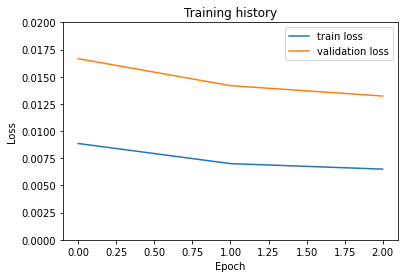

In [ ]:
# Plot graphs 
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.02]);

### Generating predictions and metrics

In [ ]:
# Load pretrained model
model = MonoTransQuest(config)
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)

In [ ]:
# Function to calculate predictions on test set
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  originals = []
  translations = []

  with torch.no_grad():
    for d in data_loader:
      ori = d["original_text"]
      trans = d["translation_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = torch.unsqueeze(d["label"], 1)
      labels = labels.float()
      labels = labels.to(device)
      preds = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      originals.extend(ori)
      translations.extend(trans)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()
  return originals, translations, predictions, real_values

In [ ]:
# Get predictions 
originals, translations, predictions, real_values = get_predictions(model,test_data_loader)

preds = predictions.numpy().squeeze()
labels = real_values.numpy().squeeze()
original = np.array(originals)
translation = np.array(translations)

df_results = pd.DataFrame()
df_results['original'] = original
df_results['translation'] = translation
df_results['z_mean'] = labels
df_results['pred_zscore'] = preds

df_results = un_fit(df_results, 'pred_zscore')

df_results.head(30)

In [ ]:
# Get evaluation metrics
pearson, _ = stats.pearsonr(df_results['pred_zscore'], df_results['z_mean'])
rmse = mean_squared_error(df_results['z_mean'], df_results['pred_zscore'], squared=False)
mae = mean_absolute_error(df_results['z_mean'], df_results['pred_zscore'])
print("Pearson: {}".format(pearson))
print("RMSE: {}".format(rmse))
print("MAE: {}".format(mae))


Pearson: 0.4660245942531315
RMSE: 0.6782948958683707
MAE: 0.5507497930966654


In [ ]:
# Save predictions to tsv
df_results.to_csv(results_path, sep = '\t', index=False)